In [1]:
import numpy as np
import pandas as pd
from data_loader import load_names_from_web, holdout_split, year_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from scipy.stats import kendalltau
import shap
import matplotlib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dfraw = load_names_from_web(category='national', hide_pre_1937=True, use_existing_files=True)
traintestval, holdout = year_split(dfraw)
trainval, test = year_split(traintestval)

In [3]:
# sorted(trainval['year'].unique())

In [4]:
def get_all_known_names(data):

    names = data.groupby(['state', 'name', 'M/F']).size().reset_index()
    names = names[['state', 'name', 'M/F']]
    return names

In [5]:
def select_top_names(data, first_year_to_predict, cutoff=10):
    '''
    Select names that have had at least one year at or above the cutoff count?
    Could also try to redo this to do the cutoff for the most recent known year's data
    '''

    data_noleak = data[data['year'] < first_year_to_predict]
    names = data_noleak[data_noleak['count'] >= cutoff][['state', 'name', 'M/F']].drop_duplicates()
    # display(names)
    data = names.merge(data, how='left', on=['state', 'name', 'M/F'])
    # display(data)

    return data

In [13]:
def evaluate(predictor, data_held_out, first_year_to_predict, metric='msle'):

    # display('data_held_out:')
    # display(data_held_out)

    most_recent_year = data_held_out['year'].max()
    
    # years_to_predict = range(most_recent_year, most_recent_year+1)
    years_to_predict = range(first_year_to_predict, first_year_to_predict+1)

    # only allow the model to see data from before the year to predict
    historical_data = data_held_out[data_held_out['year'] < first_year_to_predict]

    # display('historical_data:')
    # display(historical_data)

    # get our model's predictions
    predictions = predictor.predict(historical_data, years_to_predict)

    all_known_names = get_all_known_names(historical_data)

    for year_to_predict in years_to_predict:

        print(f'Predictions for {year_to_predict}:')

        names_to_predict = all_known_names.copy()
        names_to_predict['year'] = year_to_predict
        # display(names_to_predict)

        observed = names_to_predict.merge(data_held_out, how='left', on=['state', 'name', 'M/F', 'year'])

        # for now, fill in missing values with 2, same as FiveThirtyEight did;
        # reasoning: missing values could be 0 to 4, so average is 2
        observed['y'] = observed['count'].fillna(2)
        # observed = observed.rename(columns={'count': 'count_true'})
        # display(observed)

        score_df = observed.merge(predictions, how='left', on=['state', 'name', 'M/F', 'year'], suffixes=('_true', '_pred'))
        # display(score_df)

        y_true = score_df['y_true']
        y_pred = score_df['y_pred']

        if metric == 'msle':
            loss = mean_squared_log_error(y_true, y_pred)
            print(f'Loss: {loss}')

        if metric == 'rank':
            y_true = y_true.rank()
            y_pred = y_pred.rank()
            score = np.sum(np.abs(y_true-y_pred))/(len(y_true)*(len(y_true)-1))
            print(f'Score: {score}')

        if metric == 'rank_mae':
            y_true = y_true.rank()
            y_pred = y_pred.rank()
            loss = mean_absolute_error(y_true, y_pred)
            print(f'Loss: {loss}')

        if metric == 'kendalltau':
            y_true = y_true.rank()
            y_pred = y_pred.rank()
            tau, _ = kendalltau(y_true, y_pred)
            print(f'Tau: {tau}')
        
        top_F_true = score_df[score_df['M/F'] == 'F'][['name', 'y_true']].sort_values(by='y_true', ascending=False).reset_index(drop=True)
        top_F_pred = score_df[score_df['M/F'] == 'F'][['name', 'y_pred']].sort_values(by='y_pred', ascending=False).reset_index(drop=True)
        top_M_true = score_df[score_df['M/F'] == 'M'][['name', 'y_true']].sort_values(by='y_true', ascending=False).reset_index(drop=True)
        top_M_pred = score_df[score_df['M/F'] == 'M'][['name', 'y_pred']].sort_values(by='y_pred', ascending=False).reset_index(drop=True)
        top = pd.concat([top_F_true, top_F_pred, top_M_true, top_M_pred], axis=1, ignore_index=True)
        display(top.head(5))

In [14]:
class DummyPredictor():

    def __init__(self, strategy='naive'):
        self.strategy = strategy
    
    def predict(self, historical_data, years_to_predict):

        all_known_names = get_all_known_names(historical_data)

        predictions = []
        previous_year_data = historical_data[historical_data['year'] == years_to_predict[0] - 1].drop(columns=['year'])

        for year_to_predict in years_to_predict:

            prediction = all_known_names.copy()
            prediction['year'] = year_to_predict

            if self.strategy == 'naive':
                prediction = prediction.merge(previous_year_data, how='left', on=['state', 'name', 'M/F'])
                prediction['y'] = prediction['count'].fillna(2)
                # display(prediction)
            elif self.strategy == 'mean':
                prediction['y'] = previous_year_data['count'].mean()
                # display(prediction)

            predictions.append(prediction)

        predictions = pd.concat(predictions, ignore_index=True)
        # display(predictions)

        return predictions

In [15]:
first_year_to_predict = 2003
cutoff = 100
# data_to_fit = select_top_names(trainval, first_year_to_predict=first_year_to_predict, cutoff=0)
data_to_eval = select_top_names(test, first_year_to_predict=first_year_to_predict, cutoff=cutoff)
evaluate(predictor=DummyPredictor(strategy='naive'), data_held_out=data_to_eval, first_year_to_predict=first_year_to_predict, metric='rank')

Predictions for 2003:
Score: 0.027288780081125986


,0,1,2,3,4,5,6,7
0,Emily,25691.0,Emily,24468.0,Jacob,29650.0,Jacob,30583.0
1,Emma,22714.0,Madison,21773.0,Michael,27126.0,Michael,28256.0
2,Madison,20201.0,Hannah,18827.0,Joshua,25103.0,Joshua,25997.0
3,Hannah,17638.0,Emma,16554.0,Matthew,24009.0,Matthew,25154.0
4,Olivia,16152.0,Alexis,15636.0,Andrew,22160.0,Ethan,22112.0


In [16]:
def classify(df):

    '''
    PEAKS
    '''

    peaks = df.loc[df.groupby(['state', 'name', 'M/F'])['count'].idxmax()][['state', 'name', 'M/F', 'year']]
    peaks = peaks.rename(columns={'year': 'peak_year'})
    df = df.merge(peaks, how='left', on=['state', 'name', 'M/F'])
    # display(df)
    df['has_peaked'] = df.apply(lambda row: 1 if row['year'] >= row['peak_year'] else 0, axis=1)
    return df

In [17]:
def load_movie_data():

    movies = pd.read_csv('Data/cleaned_cast_and_characters.csv')
    movies['release_year'] = movies['release_date'].fillna('0000').str[:4].astype(int)
    return movies

movies = load_movie_data()

In [38]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

class MyPredictor():

    def __init__(self):
        
        # params
        # cols_to_keep = ['this_year', 'M/F', 'sum', 'median_age', 'thisyear_count', 'diff',] # best overall?
        # cols_to_keep = ['this_year', 'M/F', 'sum', 'median_age', 'thisyear_count', 'diff', 'first_letter_1_pct', 'first_letter_2_pct', 'first_letter_3_pct'] # first letter pct change helps in some years
        self.cols_to_keep = ['this_year', 'M/F', 'sum', 'median_age', 'thisyear_count', 'diff', 'thisyear_count_opp', 'diff2', 'shift', 'pct_change', 'accel', 'first_letter_1_pct', 'first_letter_2_pct', 'first_letter_3_pct', 'after_peak', 'years_since_peak', 'actor_recency_score', 'character_recency_score']
        categorical_features = ['M/F', 'after_peak']
        max_leaf_nodes = 63 # 31
        max_iter = 200 # 100
        loss = 'absolute_error' # abs better than default

        categorical_features = [True if f in categorical_features else False for f in self.cols_to_keep]
        # print(categorical_features)
        
        self.pipe = make_pipeline(
            ColumnTransformer(
                transformers=[
                    # ('category_encoder', LabelEncoder(), categorical_features),
                    ('cols_to_keep', 'passthrough', self.cols_to_keep),
                ], remainder='drop'),
            HistGradientBoostingRegressor(
                random_state=0,
                categorical_features=categorical_features,
                max_leaf_nodes=max_leaf_nodes,
                max_iter=max_iter,
                loss=loss
            )
        )

        self.gender_encoding = {'M': 0, 'F': 1}

        self.explainer = None

    def preprocess(self, df, latest_known_year):

        # print(f'Latest known year: {latest_known_year}')

        # find median age of people with name, 
        # total born with that name,
        # and latest year's count

        df = df.copy()

        df = classify(df)
        df['after_peak'] = df['peak_year'].apply(lambda x: 1 if x < latest_known_year else 0)

        df = df.sort_values(by='year')
        df['cumsum'] = df.groupby(['state', 'name', 'M/F'])['count'].cumsum()
        df['sum'] = df.groupby(['state', 'name', 'M/F'])['count'].transform('sum')

        df['diff'] = df.groupby(['state', 'name', 'M/F'])['count'].diff()
        df['diff2'] = df.groupby(['state', 'name', 'M/F'])['count'].diff(2)
        df['shift'] = df.groupby(['state', 'name', 'M/F'])['count'].shift()
        df['pct_change'] = df.groupby(['state', 'name', 'M/F'])['count'].pct_change()
        df['accel'] = df.groupby(['state', 'name', 'M/F'])['diff'].diff()

        percentage_of_total_per_year = {}
        percentage_change_per_year = {}

        def first_letters(df, n, percentage_of_total_per_year, percentage_change_per_year):
            df['first_letter_'+str(n)] = df['name'].str[0:n].str.lower()
            total_names_per_year = df.groupby(['year', 'state', 'M/F'])['count'].sum()
            letter_names_per_year = df.groupby(['year', 'state', 'M/F', 'first_letter_'+str(n)])['count'].sum()
            percentage_of_total_per_year[n] = (letter_names_per_year / total_names_per_year).rename('first_letter_'+str(n)+'_pct')
            # display(percentage_of_total_per_year)
            percentage_change_per_year[n] = percentage_of_total_per_year[n].groupby(['state', 'M/F', 'first_letter_'+str(n)]).pct_change().rename('first_letter_'+str(n)+'_pct_change')
            # display(percentage_change_per_year)
            return df
        
        for n in range(1, 4):
            df = first_letters(df, n, percentage_of_total_per_year, percentage_change_per_year)
        
        # display(df[(df['name'] == 'Maximus')])

        medians = df[df['cumsum'] >= df['sum']/2]
        medians = medians.drop_duplicates(subset=['state', 'name', 'M/F'], keep='first')
        medians['median_age'] = latest_known_year - medians['year']
        # display(medians[medians['name'] == 'Madison'])

        medians = medians.drop(['count', 'cumsum', 'diff', 'shift', 'pct_change', 'accel', 'diff2'], axis=1)

        thisyear = df[df['year'] == latest_known_year][['state', 'name', 'M/F', 'count', 'diff', 'shift', 'pct_change', 'accel', 'diff2']].rename(columns={'count': 'thisyear_count'})
        # thisyear = thisyear.merge(percentage_of_total_per_year, how='left', on=['year', 'state', 'M/F', 'first_letter_1'])
        # thisyear = thisyear.merge(percentage_change_per_year, how='left', on=['year', 'state', 'M/F', 'first_letter_1'])
        # thisyear = thisyear.rename(columns={'year': 'this_year'})

        sex_counts = thisyear.groupby(['state', 'name', 'M/F'])['thisyear_count'].sum()
        thisyear_swapped = thisyear.copy()
        thisyear_swapped['M/F'] = thisyear_swapped['M/F'].replace({'M': 'F', 'F': 'M'})
        thisyear_swapped = thisyear_swapped.merge(sex_counts, how='left', on=['state', 'name', 'M/F'], suffixes=('', '_opp'))
        thisyear_swapped['M/F'] = thisyear_swapped['M/F'].replace({'M': 'F', 'F': 'M'})
        thisyear_swapped['thisyear_count_opp'] = thisyear_swapped['thisyear_count_opp'].fillna(0)
        thisyear = thisyear_swapped
        # display(thisyear)

        df = medians.merge(thisyear, how='left', on=['state', 'name', 'M/F']).rename(columns={'year': 'median_year'})
        # df2[['thisyear_count']] = df2[['thisyear_count']].fillna(0) # might want to shift this to 2 and fill in 2s for missing years? or maybe not

        # this is sort of a rough assumption that if a row didn't exist for this year, not only is the count 0, but so is the diff, shift and pct_change. not always true if the prior year had a count, but often true
        df[['thisyear_count', 'diff', 'shift', 'pct_change', 'accel', 'diff2']] = df[['thisyear_count', 'diff', 'shift', 'pct_change', 'accel', 'diff2']].fillna(0)

        df['after_peak'] = df['after_peak'].fillna(1)
        df['years_since_peak'] = latest_known_year - df['peak_year']

        df['this_year'] = latest_known_year # adding this does seem to improve accuracy. we need to know how far along we are in time

        for n in range(1, 4):
            df = df.merge(percentage_of_total_per_year[n], how='left', left_on=['this_year', 'state', 'M/F', 'first_letter_'+str(n)], right_on=['year', 'state', 'M/F', 'first_letter_'+str(n)])
            df = df.merge(percentage_change_per_year[n], how='left', left_on=['this_year', 'state', 'M/F', 'first_letter_'+str(n)], right_on=['year', 'state', 'M/F', 'first_letter_'+str(n)])
            df['first_letter_'+str(n)+'_pct'] = df['first_letter_'+str(n)+'_pct'].fillna(0)
            df['first_letter_'+str(n)+'_pct_change'] = df['first_letter_'+str(n)+'_pct_change'].fillna(0)

        # display(df2)
        # display(df2.groupby(['state','name','M/F']).ngroups)

        # change M/F to 0/1 so it works with various models
        # (even HistGradientBoostingRegressor, which accepts categorical values,
        # still needs those values to be numbers not strings)
        df['M/F'] = df['M/F'].map(self.gender_encoding)

        # MOVIES
        known_movies = movies[movies['release_year'] <= latest_known_year] # avoid data leakage
        known_movies['years_since_release'] = latest_known_year - known_movies['release_year'] + 1
        known_movies['recency_score'] = 0.5 ** known_movies['years_since_release']
        actor_name_scores = known_movies.groupby('actor_first_name')['recency_score'].sum().reset_index().rename(columns={'actor_first_name': 'name', 'recency_score': 'actor_recency_score'})
        character_name_scores = known_movies.groupby('character_first_name')['recency_score'].sum().reset_index().rename(columns={'character_first_name': 'name', 'recency_score': 'character_recency_score'})
        df = df.merge(actor_name_scores, how='left', on='name')
        df = df.merge(character_name_scores, how='left', on='name')
        df['actor_recency_score'] = df['actor_recency_score'].fillna(0)
        df['character_recency_score'] = df['character_recency_score'].fillna(0)

        return df
    
    def fit(self, historical_data, first_year_to_predict, years_to_fit=1, weight_decay=0.9):
        # first things first, we don't want to know about future data
        historical_data = historical_data[historical_data['year'] < first_year_to_predict]
        # at this point the data we don't want to know should be inaccessible

        X_all = pd.DataFrame()
        y_all = pd.Series()

        # each year_to_fit is the year that's essentially our y for that loop
        for year_to_fit in range(first_year_to_predict - years_to_fit, first_year_to_predict):

            # now we "know" even less for X
            X = historical_data[historical_data['year'] < year_to_fit]
            y = historical_data[historical_data['year'] == year_to_fit]

            X = self.preprocess(X, latest_known_year=year_to_fit - 1)
            y = y[['state', 'name', 'M/F', 'count']].rename(columns={'count': 'y'})
            y['M/F'] = y['M/F'].map(self.gender_encoding)

            data = X.merge(y, how='left', on=['state', 'name', 'M/F'])
            data['y'] = data['y'].fillna(0)
            # display(data)

            X = data.drop(columns=['y'])
            y = data['y']
            X['sample_weight'] = weight_decay ** (first_year_to_predict - year_to_fit)

            X_all = pd.concat([X_all, X], ignore_index=True)
            y_all = pd.concat([y_all, y], ignore_index=True)
        
        temp = X_all.copy()
        temp['y'] = y_all
        display(temp)

        sample_weights = X_all['sample_weight']
        X_all = X_all.drop(columns=['sample_weight'])

        self.pipe.fit(X_all, y_all, **{'histgradientboostingregressor__sample_weight': sample_weights})
        # this seems like a silly way to pass params to individual steps of the pipeline, but it's true. See: https://stackoverflow.com/questions/36205850/sklearn-pipeline-applying-sample-weights-after-applying-a-polynomial-feature-t

        self.explainer = shap.Explainer(self.pipe.steps[-1][1], X_all.fillna(0)[self.cols_to_keep])

    def predict(self, historical_data, years_to_predict):

        # all_known_names = get_all_known_names(historical_data)

        predictions = []

        # display('historical_data in predict:')
        # display(historical_data)
        # display('years_to_predict:')
        # display(years_to_predict)

        for year_to_predict in years_to_predict:

            # display('historical_data in predict loop:')
            # display(historical_data)

            df = self.preprocess(historical_data, latest_known_year=year_to_predict - 1)
            # df = self.preprocess(historical_data, years_to_predict[0] - 1)

            shap_values = self.explainer.shap_values(df.fillna(0)[self.cols_to_keep])
            shap.summary_plot(shap_values, df.fillna(0)[self.cols_to_keep])
            shap_values = self.explainer(df.fillna(0)[self.cols_to_keep])
            shap.plots.bar(shap_values)
            shap.plots.beeswarm(shap_values)
            shap.plots.heatmap(shap_values)

            # for col in self.cols_to_keep:
            #     shap.plots.scatter(shap_values[:, col], color=shap_values)

            df['y'] = self.pipe.predict(df)

            df['year'] = year_to_predict
            # display(df)

            # if we want to simply, do the following; 
            # but for now, might be useful to see all data displayed.
            # df = df[['state', 'year', 'name', 'M/F', 'y']]

            predictions.append(df)

            assumed_new_year_of_historical_data = df[['state', 'year', 'name', 'M/F', 'y']].rename(columns={'y': 'count'})
            assumed_new_year_of_historical_data['M/F'] = assumed_new_year_of_historical_data['M/F'].map({v: k for k, v in self.gender_encoding.items()})
            historical_data = pd.concat([historical_data, assumed_new_year_of_historical_data], ignore_index=True)

        predictions = pd.concat(predictions, ignore_index=True)

        # we have to reverse the mapping to send our predictions
        # (at least the way we currently have it set up)
        predictions['M/F'] = predictions['M/F'].map({v: k for k, v in self.gender_encoding.items()})

        predictions.loc[predictions['y'] < 4.5, 'y'] = 2

        display(predictions)
        # display(predictions[predictions['y'] < 4.5])

        return predictions


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,state,name,M/F,median_year,peak_year,has_peaked,after_peak,sum,first_letter_1,first_letter_2,...,first_letter_1_pct,first_letter_1_pct_change,first_letter_2_pct,first_letter_2_pct_change,first_letter_3_pct,first_letter_3_pct_change,actor_recency_score,character_recency_score,sample_weight,y
0,US,Payne,0,1939,1939,1,1,5,p,pa,...,0.025762,-0.054110,0.015780,-0.076863,0.000012,-0.230727,1.401531e-09,0.000069,0.042391,0.0
1,US,Shelba,1,1940,1937,1,1,1917,s,sh,...,0.099260,-0.016319,0.037125,-0.033103,0.016027,-0.045598,0.000000e+00,0.000000,0.042391,5.0
2,US,Memphis,0,1940,1937,1,1,24,m,me,...,0.098125,0.005348,0.001219,0.000208,0.000000,0.000000,3.125000e-02,0.000000,0.042391,0.0
3,US,Shelva,1,1940,1937,1,1,1010,s,sh,...,0.099260,-0.016319,0.037125,-0.033103,0.016027,-0.045598,0.000000e+00,0.000000,0.042391,0.0
4,US,Harlie,1,1940,1940,1,1,5,h,ha,...,0.021586,0.111901,0.000728,0.069237,0.000113,-0.059809,0.000000e+00,0.000000,0.042391,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159401,US,Imanol,0,2001,2001,1,0,278,i,im,...,0.018344,0.090769,0.000194,0.908697,0.000095,2.500817,3.125000e-02,0.000000,0.900000,100.0
159402,US,Jaheim,0,2001,2001,1,0,564,j,ja,...,0.178923,-0.000809,0.069461,0.028025,0.000470,43.874998,0.000000e+00,0.000000,0.900000,752.0
159403,US,Jaheem,0,2001,2001,1,0,208,j,ja,...,0.178923,-0.000809,0.069461,0.028025,0.000470,43.874998,0.000000e+00,0.000000,0.900000,182.0
159404,US,Jahiem,0,2001,2001,1,0,155,j,ja,...,0.178923,-0.000809,0.069461,0.028025,0.000470,43.874998,0.000000e+00,0.000000,0.900000,235.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 98%|===================| 5480/5609 [00:25<00:00]        

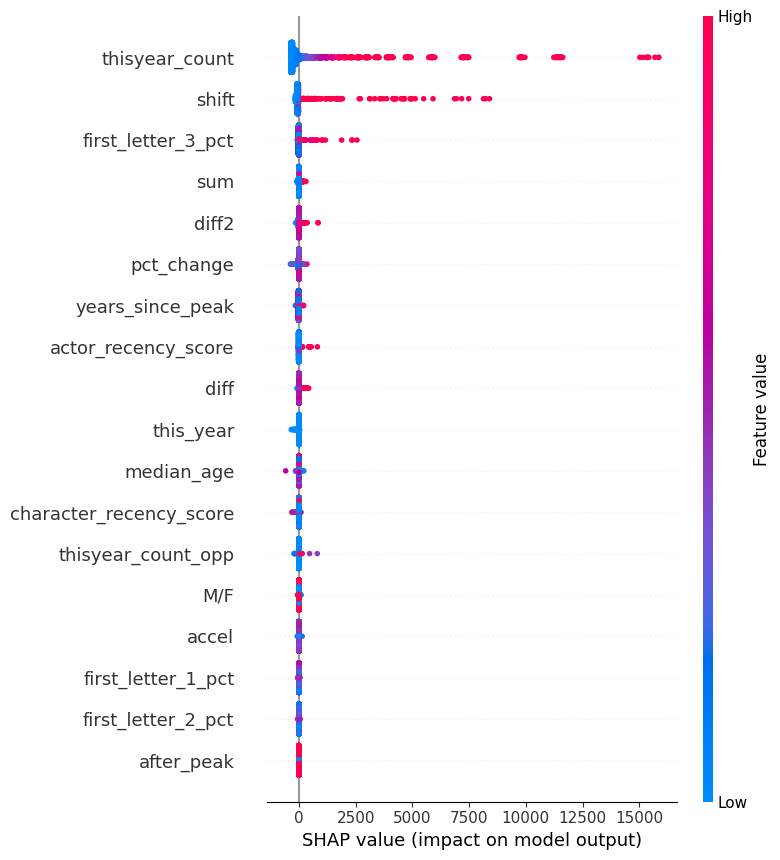

 97%|=================== | 5445/5609 [00:25<00:00]       

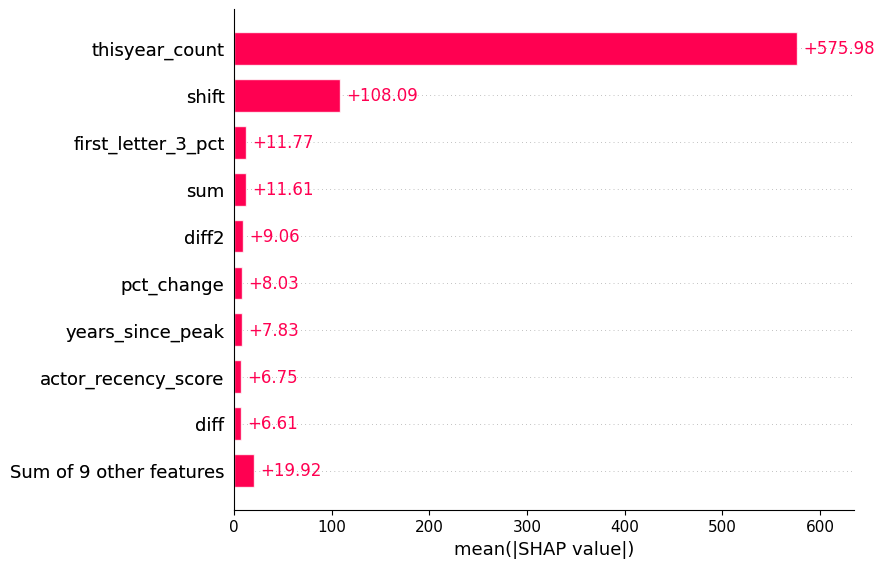

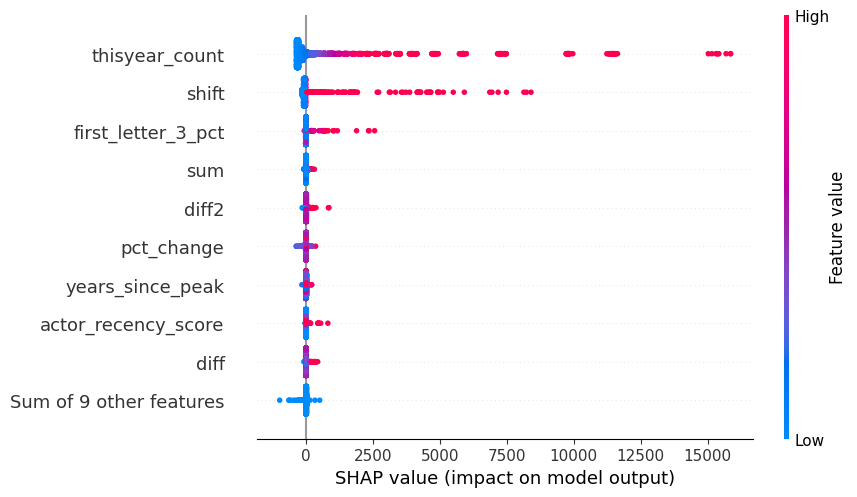

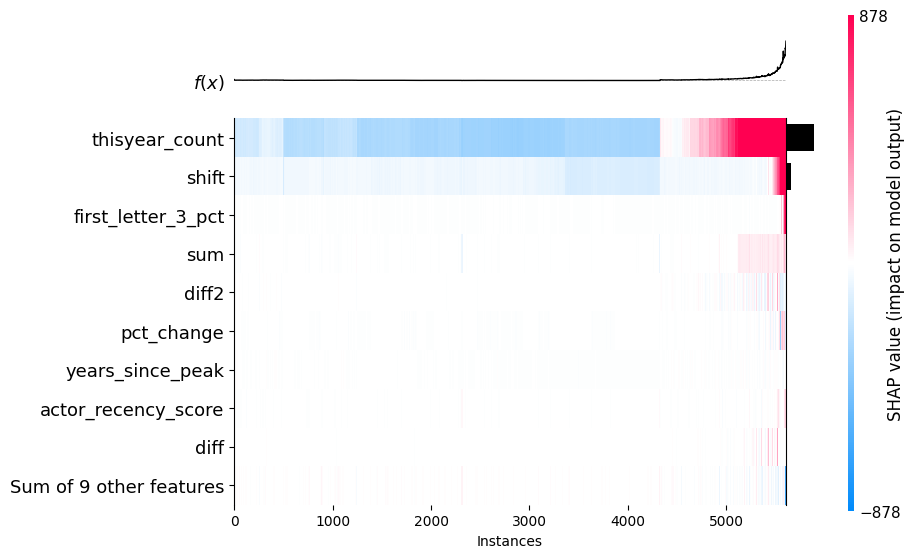

,state,name,M/F,median_year,peak_year,has_peaked,after_peak,sum,first_letter_1,first_letter_2,...,first_letter_1_pct,first_letter_1_pct_change,first_letter_2_pct,first_letter_2_pct_change,first_letter_3_pct,first_letter_3_pct_change,actor_recency_score,character_recency_score,y,year
0,US,Shelva,F,1940,1937,1,1,1028,s,sh,...,0.082283,-0.017463,0.010929,-0.061451,0.003818,-0.100467,0.000000e+00,0.000000,2.000000,2003
1,US,Shelba,F,1941,1937,1,1,1964,s,sh,...,0.082283,-0.017463,0.010929,-0.061451,0.003818,-0.100467,0.000000e+00,0.000000,2.000000,2003
2,US,Melvyn,M,1942,1938,1,1,3100,m,me,...,0.069485,-0.029089,0.001045,0.342911,0.000530,0.667318,4.434167e-06,0.000000,10.373178,2003
3,US,Dick,M,1944,1937,1,1,14088,d,di,...,0.077368,-0.018639,0.003840,0.122545,0.000003,0.018295,4.602687e+00,2.445844,2.000000,2003
4,US,Shirley,M,1944,1937,1,1,3411,s,sh,...,0.042288,-0.026673,0.004750,-0.043263,0.000045,-0.205373,6.452862e+00,1.286142,2.000000,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5604,US,Gael,M,2002,2002,1,0,453,g,ga,...,0.029835,0.046564,0.016575,0.092108,0.000138,4.250878,5.000000e-01,0.000000,244.686611,2003
5605,US,Cael,M,2002,2002,1,0,372,c,ca,...,0.091285,-0.026447,0.027827,0.005712,0.000263,0.792005,0.000000e+00,0.000000,265.805987,2003
5606,US,Jersey,F,2002,2002,1,0,198,j,je,...,0.082090,-0.009692,0.020074,-0.079883,0.000236,-0.000577,7.105427e-15,0.031433,116.914440,2003
5607,US,Jahiem,M,2002,2002,1,0,390,j,ja,...,0.179050,0.000706,0.069890,0.006183,0.000656,0.396143,0.000000e+00,0.000000,282.504783,2003


Predictions for 2003:
Score: 0.025458117163952677


,0,1,2,3,4,5,6,7
0,Emily,25691.0,Emily,23644.024344,Jacob,29650.0,Michael,28435.995849
1,Emma,22714.0,Madison,23457.927212,Michael,27126.0,Jacob,27062.560363
2,Madison,20201.0,Abigail,18356.997706,Joshua,25103.0,Joshua,25658.655752
3,Hannah,17638.0,Alexis,17263.544873,Matthew,24009.0,Matthew,24241.418100
4,Olivia,16152.0,Elizabeth,16365.091127,Andrew,22160.0,Andrew,23136.485817


In [39]:
first_year_to_predict = 2003
cutoff = 100
my_predictor = MyPredictor()
data_to_fit = select_top_names(trainval, first_year_to_predict=first_year_to_predict, cutoff=cutoff)
data_to_eval = select_top_names(test, first_year_to_predict=first_year_to_predict, cutoff=cutoff)
my_predictor.fit(historical_data=data_to_fit, first_year_to_predict=first_year_to_predict, years_to_fit=30)
evaluate(predictor=my_predictor, data_held_out=data_to_eval, first_year_to_predict=first_year_to_predict, metric='rank')